# Applying Regression on Stock Prices  
In this notebook we will be applying a number of regression algorithms present in the Scikit Learn library. 


In [20]:
%config IPCompleter.greedy=True

In [21]:
# Lets import a few important libraries first
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling 

In [22]:
# yFinance will help us fetch the data for our dataset
import yfinance as yf

## Fetch Data from Yahoo Finance
Time to fetch some data from Yahoo!. We are going to pull 5 years price data of  
FAANG - Facebook Apple Amazon Netflix Google  


In [23]:
# Facebook
data_FB = yf.download("FB", start="2014-01-01", end="2019-09-10")
# Apple
data_AAPL = yf.download("AAPL", start="2014-01-01", end="2019-09-10")
# Amazon
data_AMZN = yf.download("AMZN", start="2014-01-01", end="2019-09-10")
# Netflix
data_NFLX = yf.download("NFLX", start="2014-01-01", end="2019-09-10")
# Google/Alphabet
data_GOOGL = yf.download("GOOGL", start="2014-01-01", end="2019-09-10")

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [24]:
# Validate the Data
# Shape should be same
display(type(data_FB))
display(data_FB.head())
display(data_FB.shape)
display(data_AAPL.shape)
display(data_AMZN.shape)
display(data_NFLX.shape)
display(data_GOOGL.shape)

pandas.core.frame.DataFrame

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-31,54.12,54.86,53.91,54.65,54.65,43076200
2014-01-02,54.83,55.22,54.19,54.71,54.71,43195500
2014-01-03,55.02,55.65,54.53,54.56,54.56,38246200
2014-01-06,54.42,57.26,54.05,57.20,57.20,68852600
2014-01-07,57.70,58.55,57.22,57.92,57.92,77207400


(1432, 6)

(1432, 6)

(1432, 6)

(1432, 6)

(1432, 6)

## Combine all the Dataframes  
Let's create a single dataframe that contains date and the _Adj Close_ price for each stock.

In [25]:
# Drop all columns except for the Adj Close price 
data_FB = data_FB[['Adj Close']]
data_AAPL = data_AAPL[['Adj Close']]
data_AMZN = data_AMZN[['Adj Close']]
data_NFLX = data_NFLX[['Adj Close']]
data_GOOGL = data_GOOGL[['Adj Close']]

# Merge the Dataframes
stock_data = data_GOOGL.merge(data_AAPL, on='Date', how='left')\
            .merge(data_AMZN, on='Date', how='left')\
            .merge(data_FB, on='Date', how='left')\
            .merge(data_NFLX, on='Date', how='left')
# Fix the column names 
stock_data.columns = ['GOOGL', 'AAPL', 'AMZN', 'FB', 'NFLX']
display(stock_data)

,GOOGL,AAPL,AMZN,FB,NFLX
Date,,,,,
2013-12-31,560.92,72.34,398.79,54.65,52.60
2014-01-02,557.12,71.32,397.97,54.71,51.83
2014-01-03,553.05,69.75,396.44,54.56,51.87
2014-01-06,559.22,70.13,393.63,57.20,51.37
2014-01-07,570.00,69.63,398.03,57.92,48.50
...,...,...,...,...,...
2019-09-03,1169.55,205.70,1789.84,182.39,289.29
2019-09-04,1182.27,209.19,1800.62,187.14,291.52
2019-09-05,1212.19,213.28,1840.72,190.90,293.25


## Calculate Daily Returns 
Instead of directly working with the stock prices, we are going to calculate the _log of Daily Returns_.  
We are going to try and predict the log returns instead of closing prices. 

In [26]:
# Stock Returns 
stock_returns = pd.DataFrame(np.log(stock_data) - np.log(stock_data.shift(1)))
# Drop the first row (need two dates to calculate returns, so NAN returns for the first day)
stock_returns.dropna(axis='index', how='any', inplace=True)
display(stock_returns.shape)
display(stock_returns)

(1431, 5)

,GOOGL,AAPL,AMZN,FB,NFLX
Date,,,,,
2014-01-02,-0.006798,-0.014200,-0.002058,0.001097,-0.014747
2014-01-03,-0.007332,-0.022259,-0.003852,-0.002745,0.000771
2014-01-06,0.011095,0.005433,-0.007113,0.047253,-0.009686
2014-01-07,0.019093,-0.007155,0.011116,0.012509,-0.057491
2014-01-08,0.002086,0.006299,0.009726,0.005338,0.004321
...,...,...,...,...,...
2019-09-03,-0.017780,-0.014671,0.007599,-0.017824,-0.015299
2019-09-04,0.010817,0.016824,0.006005,0.025710,0.007679
2019-09-05,0.024992,0.019363,0.022026,0.019893,0.005917


## EDA on the Stock Returns Data 
Time for some exploratory data analysis on the Stocks returns dataframe.  
Pandas Profiling in Action! 

In [27]:
pandas_profiling.ProfileReport(stock_returns)

### Partial Autocorrelation 
As we can see above, the returns look to be highly correlated.  
Accurately predicting them is going to be hard.
<br/><br/>Let's examine the partial autocorrelation of the return series of each stock. 

In [28]:
# An important import
from statsmodels.graphics.tsaplots import plot_pacf

In [29]:
# Set the size of the plots
plt.rcParams['figure.figsize'] = [12, 6]

In [30]:
def plot_partial_autocorr(series, plot_title, lags):
    """
    Plots the partial autocorrelations plots. 

    Parameters
    ----------
    series : Pandas Series   
        Time series whose partial autocorrelations are to be 
        plotted.
    plot_title : String
        Title of the plot.
    lag : integer
        Lag for the partial autocorrelation plots.  
        
    Returns
    -------
    None. Just plots the plot. 
    """
    
    plot_pacf(series, lags=lags)
    plt.title(plot_title, fontdict={'fontsize':25}, x=0.5, y=0.6)
    plt.show()
    
    return None    

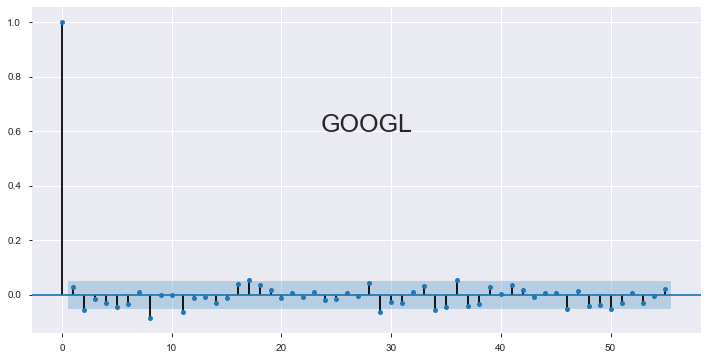

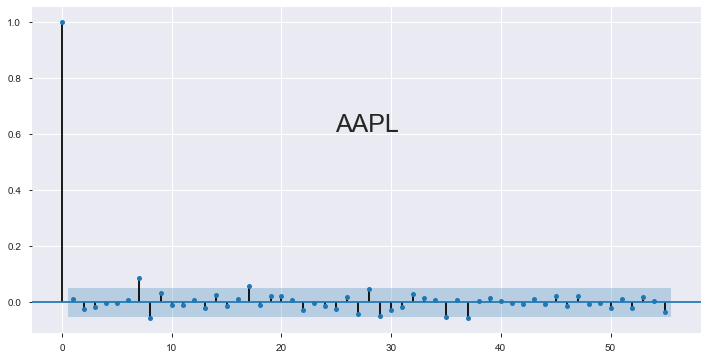

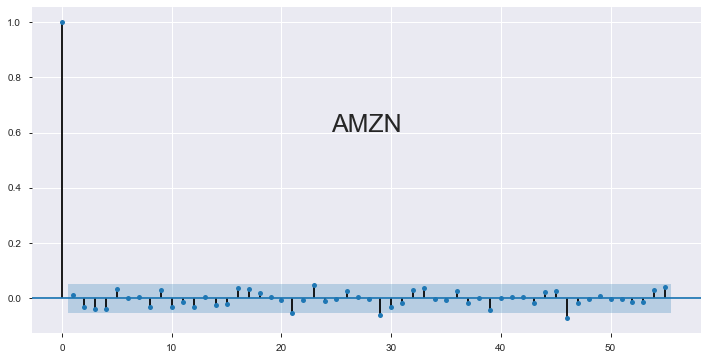

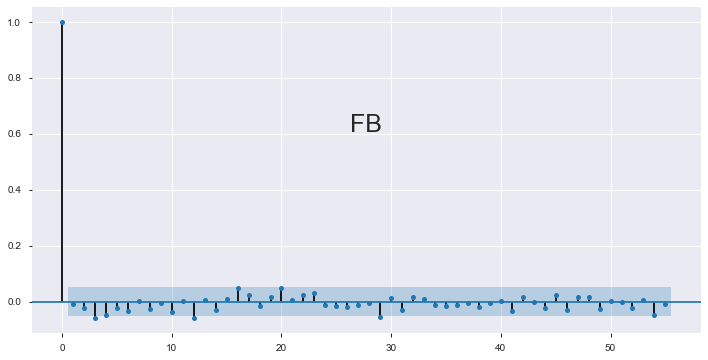

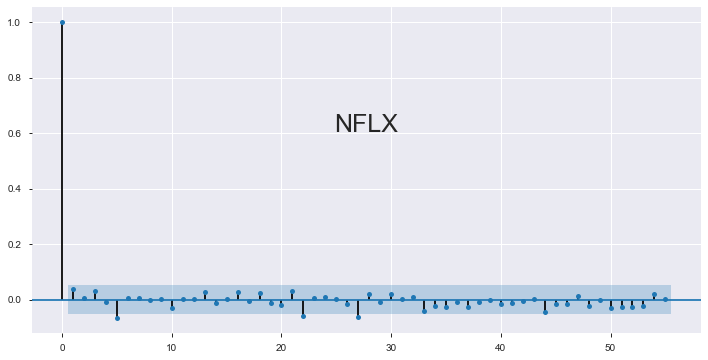

In [31]:
for column in stock_returns.columns:
    plot_partial_autocorr(series=stock_returns[column], plot_title=column, lags=55)

## Predicting Returns using Regression
As we can see from the graphs above, there's pretty much _**NO**_ correlation in the stocks returns time series.  
This implies that historical returns have virtually no predictive effect on the current return.

<br/>With this knowledge in hand, if we try to predict the returns of the above stocks, we should expect a prediction accuracy of around 50%. Since we are practically trying to predict a random variable over here.

<br/>Let's try to predict the stock returns using regression. 

In [32]:
# Import some important things 
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [33]:
# Let's try simple Ridge Regression on Google Returns 
# The regression algorithms in sklearn expect the inputs 
# as 2D arrays, in the form of (n_samples, n_targets). 
# Therefore, we will have to reshape our returns series. 
X_googl = stock_returns['GOOGL'].values.reshape(-1, 1)
# Check
print(X_googl.shape)
display(X_googl[:20])

# The labels Y are going to be nothing but the stock 
# returns for the next day. 
Y_googl = stock_returns['GOOGL'].shift(-1).dropna(how='all').values.reshape(-1,1)
# Check
display(Y_googl)
display(Y_googl.shape)

# Since the Y_googl is 1 short than the X_googl (no future return for the last day!)
# We are going to impute the last row from X_googl
X_googl = np.delete(X_googl, len(X_googl)-1, 0)
# Check 
print(X_googl.shape)

(1431, 1)


array([[-6.79763628e-03],
       [-7.33224323e-03],
       [ 1.10945423e-02],
       [ 1.90934052e-02],
       [ 2.08554304e-03],
       [-9.67567889e-03],
       [-5.30339860e-05],
       [-6.40237709e-03],
       [ 2.32660649e-02],
       [-6.95555429e-04],
       [ 6.60560495e-03],
       [-4.93708399e-03],
       [ 1.13791622e-02],
       [ 1.13254182e-03],
       [-4.22782742e-03],
       [-3.17581431e-02],
       [-2.03122864e-02],
       [ 1.95831058e-02],
       [-1.44436602e-02],
       [ 2.53963233e-02]])

array([[-0.00733224],
       [ 0.01109454],
       [ 0.01909341],
       ...,
       [ 0.02499232],
       [-0.00485424],
       [-0.00087079]])

(1430, 1)

(1430, 1)


### Preprocess and Align the Data 
Observing the preprocessing steps above, let's create a function for that.  
Also, split for the test and train sets.

In [34]:
def preprocess_align_split(series, test_size):
    """
    Preprocesses the input stock returns series. 
    Aligns the X and Y lables. 
    Returns the training and test sets.

    Parameters
    ----------
    series : Pandas Series   
    Series that is going to be preprocessed.
    test_size : Float
    A value > 0 and < , that specifies the size 
    of the testing set. 

    Returns
    -------
    X_train, X_test, y_train, y_test : np.array
    Numpy arrays of training and testing sets. 
    """
    # Ensure data sanity
    assert 0 < test_size < 1, 'Value of test_size should be between 0 & 1.'
    
    # Reshape the series for X values 
    X = series.values.reshape(-1, 1)
    # Remove the last row, as there wil be no Y value for that 
    X = np.delete(X, len(X)-1, 0)
    
    # Shift the series values by 1 to create Y
#     Y = series.shift(-1).dropna(how='all').values.reshape(-1, 1)
    Y = series.shift(-1).dropna(how='all').values
    
    # Split the data for the train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=0)
    
    return X_train, X_test, y_train, y_test

In [35]:
# Let's preprocess the FB returns data 
X_train, X_test, y_train, y_test = preprocess_align_split(stock_returns['FB'], test_size=0.15)
# Check - Train and Test shapes should match
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1215, 1)

(215, 1)

(1215,)

(215,)

### Train the Regression Models
We will train 3 types of regression models 
1. Ridge Regression 
2. Bayesian Ridge Regression
3. RANSAC Regression

In [36]:
def return_regressors(X_train, y_train):
    """
    Trains and returns 3 different regression models. 

    Parameters
    ----------
    X_train : numpy array   
    Independent variable in Regression
    Y_train : numpy arrray
    Dependent variable in Regression

    Returns
    -------
    ridge : sklearn Linear Model
    Trained Ridge regressor
    bayesian : sklearn Linear Model
    Trained Bayesian Ridge regressor
    ransac : sklearn Linear Model
    Trained RANSAC regressor
    """
    # Data Sanity check
    assert X_train.shape[0] == y_train.shape[0], 'X and y train should have equal number of rows.'
    
    # Ridge Regressor 
    ridge = linear_model.Ridge(alpha=0.5, fit_intercept=False)
    ridge.fit(X_train, y_train)
    
    # Bayesian Regressor
    bayesian = linear_model.BayesianRidge(fit_intercept=False)
    bayesian.fit(X_train, y_train)
    
    # RANSAC Regressor 
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X_train, y_train)
    
    return ridge, bayesian, ransac

### Evaluate the Regression Models 
Now that we have trained our regression models, time to evaluate their performance.  
We will be calculating the following metrics for our models
1. Mean Absolute Error
2. Mean Squared Error 
3. $R^{2}$ Score


In [37]:
def calculate_metrics(y_true, y_pred):
    """
    Calculates the regression model's performance metrics. 

    Parameters
    ----------
    y_true : numpy array   
    Actual values. 
    y_pred : numpy arrray
    Values predicted by the model.

    Returns
    -------
    mae : Float
    Mean Absolute Error
    mse : Float
    Mean Squared Error
    r2 : Float
    R2 Score 
    """
    # Data Sanity check
    assert len(y_true) == len(y_pred), 'y_true and y_pred should have equal number of rows.'
    
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y_true, y_pred)
    # Mean Squared Error
    mse = metrics.mean_squared_error(y_true, y_pred)
    # R2
    r2 = metrics.r2_score(y_true, y_pred)
    
    return mae, mse, r2

### Prediction Time! 
Time to put our data and regression models to action! 

GOOGL Stock
Ridge Regression
Mean Absolute Error = 0.01120
Mean Squared Error = 0.00025
R2 Score = -0.00563

Bayesian Regression
Mean Absolute Error = 0.01119
Mean Squared Error = 0.00025
R2 Score = -0.00656

RANSAC Regression
Mean Absolute Error = 0.01131
Mean Squared Error = 0.00025
R2 Score = -0.01035



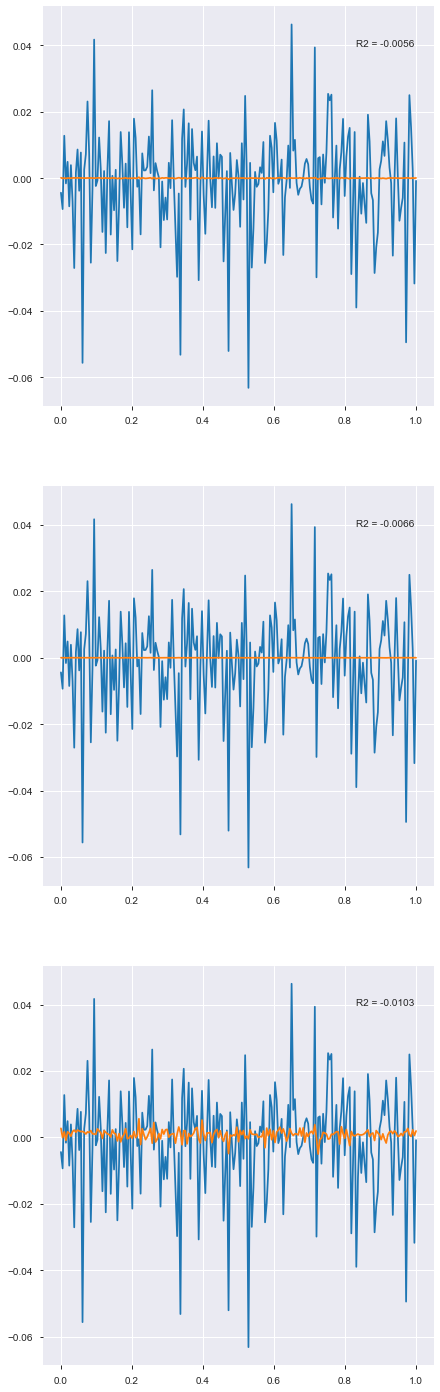





AAPL Stock
Ridge Regression
Mean Absolute Error = 0.01078
Mean Squared Error = 0.00023
R2 Score = -0.00145

Bayesian Regression
Mean Absolute Error = 0.01078
Mean Squared Error = 0.00023
R2 Score = -0.00056

RANSAC Regression
Mean Absolute Error = 0.01121
Mean Squared Error = 0.00024
R2 Score = -0.05815



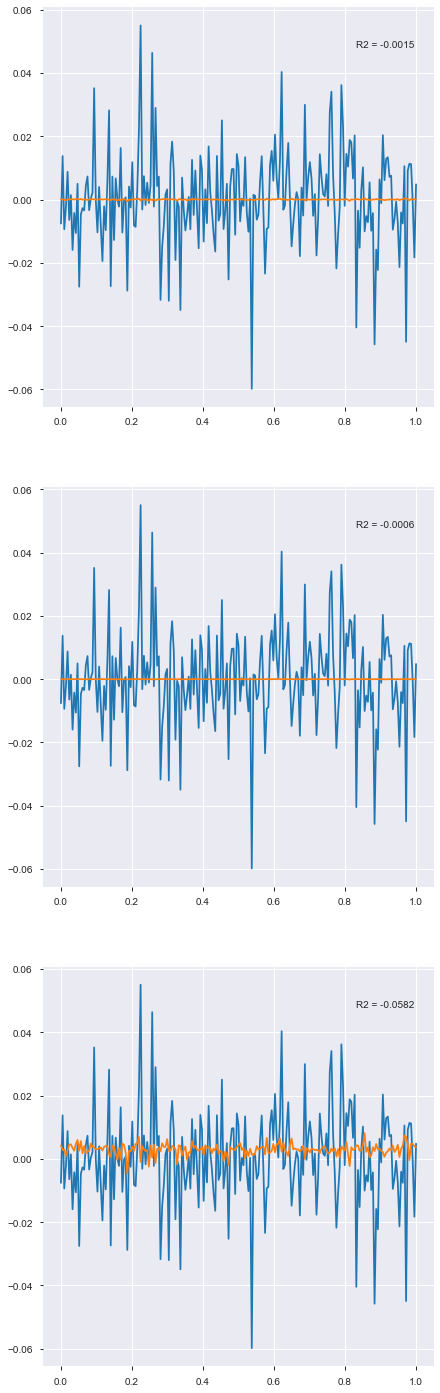





AMZN Stock
Ridge Regression
Mean Absolute Error = 0.01449
Mean Squared Error = 0.00055
R2 Score = -0.00104

Bayesian Regression
Mean Absolute Error = 0.01449
Mean Squared Error = 0.00055
R2 Score = -0.00093

RANSAC Regression
Mean Absolute Error = 0.01456
Mean Squared Error = 0.00055
R2 Score = -0.01015



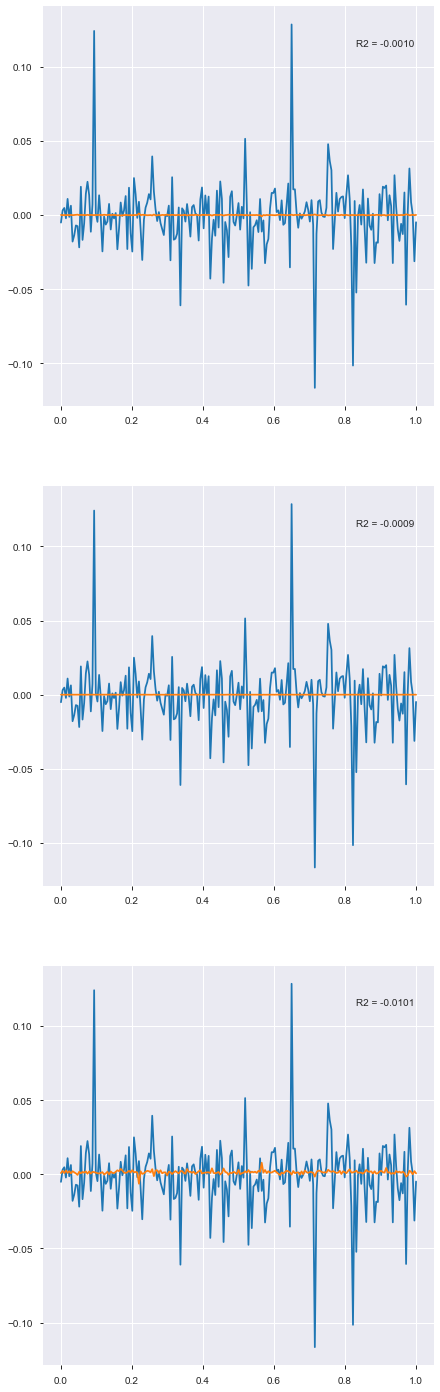





FB Stock
Ridge Regression
Mean Absolute Error = 0.01558
Mean Squared Error = 0.00067
R2 Score = -0.00284

Bayesian Regression
Mean Absolute Error = 0.01558
Mean Squared Error = 0.00067
R2 Score = -0.00278

RANSAC Regression
Mean Absolute Error = 0.01615
Mean Squared Error = 0.00070
R2 Score = -0.05264



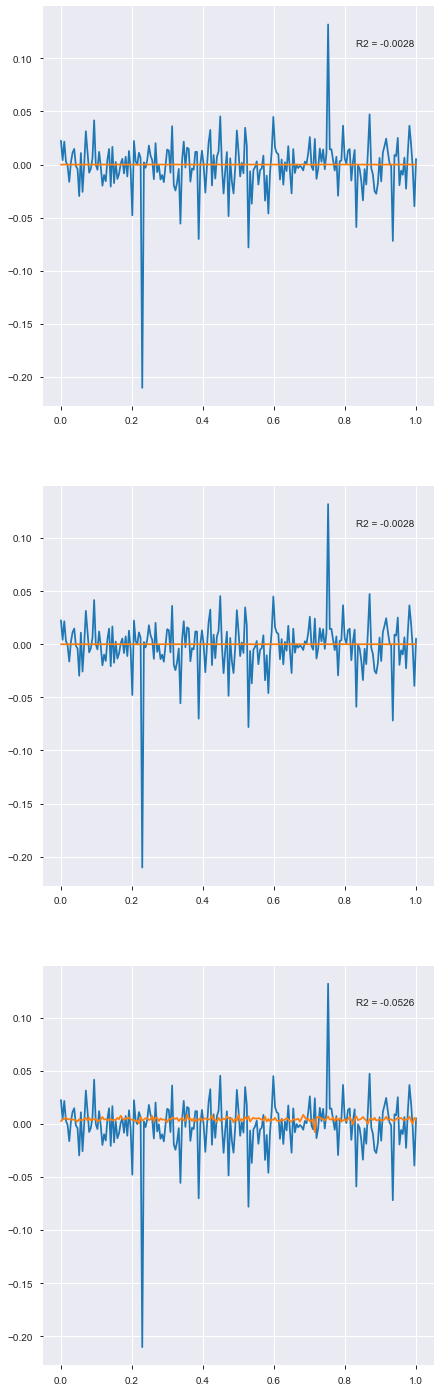





NFLX Stock
Ridge Regression
Mean Absolute Error = 0.01688
Mean Squared Error = 0.00075
R2 Score = -0.00340

Bayesian Regression
Mean Absolute Error = 0.01688
Mean Squared Error = 0.00075
R2 Score = -0.00348

RANSAC Regression
Mean Absolute Error = 0.01679
Mean Squared Error = 0.00075
R2 Score = -0.00388



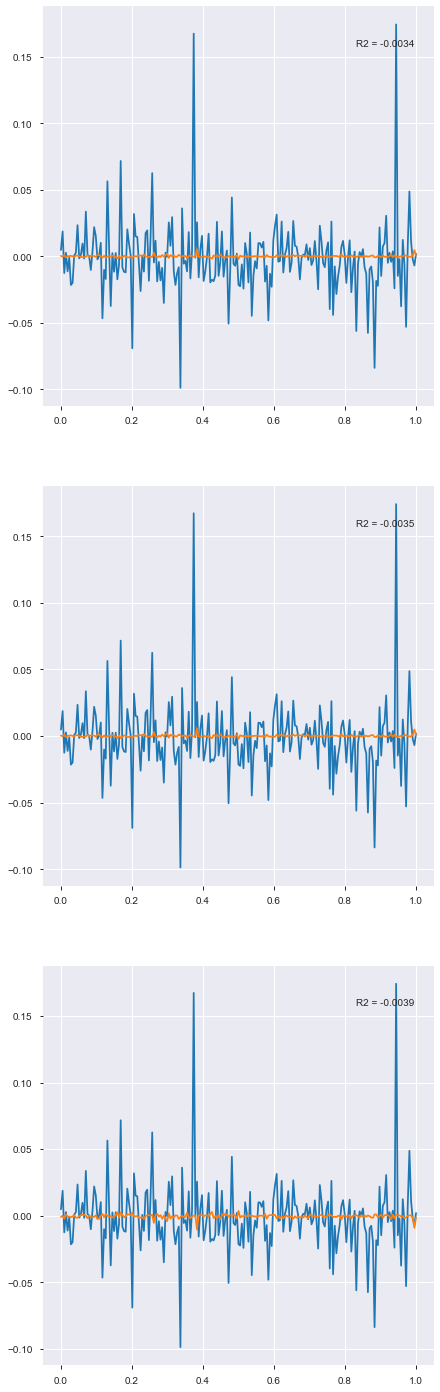

In [38]:
regressor = ['Ridge', 'Bayesian', 'RANSAC']
for column in stock_returns.columns:
    # Extract and preprocess the individual stock data
    # Train Set = 85% ; Test Set = 15%
    X_train, X_test, y_train, y_test = preprocess_align_split(stock_returns[column], test_size=0.15)
    # Train the Regression models 
    ridge, bayesian, ransac = return_regressors(X_train, y_train)
    # Predict on the test set using the 3 models
    y_preds = [ridge.predict(X_test), bayesian.predict(X_test), ransac.predict(X_test)]
    
    # Calculate the prediction metrics for each regressor
    print(f'{column} Stock')
    fig, ax = plt.subplots(nrows=len(regressor), ncols=1, figsize=(7, 25))
    for name, y_pred in enumerate(y_preds):
        mae, mse, r2 = calculate_metrics(y_true=y_test, y_pred=y_pred)
        # Print the metrics 
        print(f'{regressor[name]} Regression')
        print(f'Mean Absolute Error = {mae:.5f}')        
        print(f'Mean Squared Error = {mse:.5f}')        
        print(f'R2 Score = {r2:.5f}\n')
        # Plot the results 
        plt.subplot(len(regressor), 1, name+1)
        ax = plt.gca()
        plt.plot(np.linspace(0,1, len(y_test)), y_test)
        plt.plot(np.linspace(0,1, len(y_test)), y_preds[name])
        ax.text(0.8, 0.9, f'R2 = {r2:.4f}', transform=ax.transAxes)
    plt.show()
    
    print('\n\n\n')

## Conclusion 
As we can see from the performance metrics and the prediction graphs above, it is really hard to predict stock returns.  
Note the $R^{2}$ score for all the models. It is _**NEGATIVE**_!  
This implies that the regression models are performing extremely bad. So much, that they hardly have any predictive power for the future.  
_**This result shows that predicting stock returns is an extremely difficult problem to solve.**_ 

### Better Approach  
There are a number of ways in which this problem can be better approached and we can expect to obtain improved results. 
1. Train and predict the returns over a set number of periods using _walk-forward method_. 
    - For example, train the model for 20 days, then predict the return for $21^{st}$ day. 
    - Repeat till you reach the end of the time series. 
2. Instead of using linear regression models, use non-linear models along with walk-forward method. 
3. Use _**Factor Models**_, determine factors that positively and negatively affect the stock price. 
4. Train a non-linear Deep Neural Networks based algorithm on Factor Models. 

The last option, is arguably the ideal way to predict stock returns at the moment. 